In [1]:
import torch
from matplotlib import pyplot as plt

In [2]:
from miscellaneous.dataloader import FHA_Unsupervised
from miscellaneous.augumentation import FreqencyAugumentation, TimeAugumentation

In [64]:
import numpy as np
from scipy.signal import butter, lfilter
class TimeAugumentation:
    def __init__(self, fs, mask_rate, sigma):
        '''
        fs: int sampling rate
        mask_rate: float, mask rate
        sigma: float, jitter sigma
        '''
        self.mask_rate = mask_rate
        self.sigma = sigma
        self.initialize(fs)

    def initialize(self, fs):
        self.filters = {}
        for i in range(1, 30, 5):
            self.filters[i] = self.compute_filter_coefficients(fs, [i, i+5])

    def compute_filter_coefficients(self, fs, cutoffs):
        nyquist = 0.5 * fs
        low = cutoffs[0] / nyquist
        high = cutoffs[1] / nyquist
        b, a = butter(5, [low, high], btype='bandstop')
        return b, a
    
    def _BandStopFilter(self, x, coeffs):
        b, a = coeffs
        return lfilter(b, a, x)
    
    def _masking(self, x):
        mask = np.random.binomial(1, 1-self.mask_rate, x.shape[-1])
        return x * mask
    
    def _jitter(self, x):
        return x + np.random.normal(loc=0., scale=self.sigma, size=x.shape[-1])

    def __call__(self, x):
        filter_coeff = np.random.choice(list(self.filters.keys()),2)
        x = self._BandStopFilter(x, self.filters[filter_coeff[0]])
        x = self._BandStopFilter(x, self.filters[filter_coeff[1]])
        x = self._jitter(x)
        x = self._masking(x)
        return x

In [65]:
import numpy as np
TIME_AUG = TimeAugumentation(256, 0.5, 0.1)
FREQ_AUG = FreqencyAugumentation(256,4,0.1)

def normalize(x:dict):
    x['EEG_Raw'] = (x['EEG_Raw'] - x['EEG_Raw'].mean(axis=-1, keepdims=True)) / (x['EEG_Raw'].std(axis=-1, keepdims=True) + 1e-6)
    return x

def FFT(x:dict):
    x['Freq'] = np.log(abs(np.fft.rfft(x['EEG_Raw'], axis=-1)) + 1e-6).astype(np.float32)
    return x

def augument(x:dict):
    x['EEG_Raw_Aug'] = TIME_AUG(x['EEG_Raw']).astype(np.float32)
    x['Freq_Aug'] = FREQ_AUG(x['Freq']).astype(np.float32)
    return x

def sample_channel(x:dict):
    x['EEG_Raw'] = x['EEG_Raw'][0:1, :]
    return x

def composer(*funcs):
    def compose(x):
        for f in funcs:
            x = f(x)
        return x
    return compose

In [67]:
preprocess = composer(normalize, FFT, augument)
dataset_config={'channels': 1, 'window_size':256*4, 'sampling_rate':256, 'access_pattern':'random', 'label':['ComorbidityLevelDesc'], 'preprocess':preprocess}
dataset = FHA_Unsupervised(r"E:\EEG\FHA\Resting\001_a01_01\Annotations\Burnaby_Chunks.csv", r"E:\EEG\FHA\Resting\chunks", dataset_config)

from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=0)

In [104]:
preprocess = composer(sample_channel,normalize,)
dataset_config={'channels': 20, 'window_size':256*4, 'sampling_rate':256, 'access_pattern':'random', 'label':['ComorbidityLevelDesc', 'CMG'],'preprocess':preprocess}
dataset_eval = FHA_Unsupervised(r"E:\EEG\FHA\Resting\001_a01_01\Annotations\Burnaby_Chunks.csv", r"E:\EEG\FHA\Resting\chunks", dataset_config, )

from torch.utils.data import DataLoader
dataloader_eval = DataLoader(dataset_eval, batch_size=64, shuffle=False, num_workers=0)

In [105]:
dataset[0]['EEG_Raw'].shape, dataset[0]['Freq'].shape, dataset[0]['EEG_Raw_Aug'].shape, dataset[0]['Freq_Aug'].shape, dataset[0]['ComorbidityLevelDesc']

((1, 1024), (1, 513), (1, 1024), (1, 513), 0)

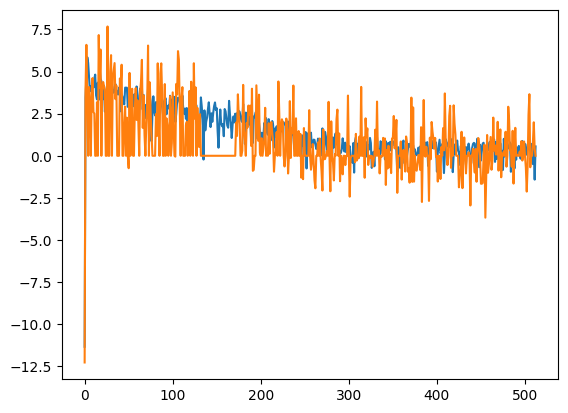

In [76]:
data = dataset[0]
plt.plot(data['Freq'][0])
plt.plot(data['Freq_Aug'][0])

In [100]:
from miscellaneous.loss import NTXentLoss_poly

def one_epoch(model, dataloader, batch_size, optimizer, criteria, device):
    model.train()
    model.to(device)
    total_loss = 0
    for i, batch in enumerate(dataloader):
        if batch['EEG_Raw'].shape[0] < batch_size:
            continue
        data_t = batch['EEG_Raw'].to(device)
        data_f = batch['Freq'].to(device)
        data_t_aug = batch['EEG_Raw_Aug'].to(device)
        data_f_aug = batch['Freq_Aug'].to(device)

        optimizer.zero_grad()
        h_t, z_t, h_f, z_f = model(data_t, data_f)
        h_t_aug, z_t_aug, h_f_aug, z_f_aug = model(data_t_aug, data_f_aug)

        loss_t = criteria(h_t, h_t_aug)
        loss_f = criteria(h_f, h_f_aug)
        l_TF = criteria(z_t, z_f) # this is the initial version of TF loss
        loss = 0.2*(loss_t + loss_f) + l_TF
        loss.backward()
        optimizer.step()
        total_loss += loss
    on_batch_end(z_t.detach().cpu().numpy())
    return total_loss / i

def on_batch_end( z):
    corr_matrix = np.corrcoef(z)
    plt.imshow(corr_matrix, interpolation='nearest')
    plt.colorbar()
    plt.title('Correlation Matrix')
    plt.savefig('correlation_matrix.png')
    plt.close()

def test(model, dataloader,criteria,  device):
    model.train()
    model.cuda()
    for i, batch in enumerate(dataloader):
        data_t = batch['EEG_Raw'].to(device)
        data_f = batch['Freq'].to(device)
        data_t_aug = batch['EEG_Raw_Aug'].to(device)
        data_f_aug = batch['Freq_Aug'].to(device)

        h_t, z_t, h_f, z_f = model(data_t, data_f)
        h_t_aug, z_t_aug, h_f_aug, z_f_aug = model(data_t_aug, data_f_aug)

        loss_t = criteria(h_t, h_t_aug)
        loss_f = criteria(h_f, h_f_aug)
        l_TF = criteria(z_t, z_f)
        break
    print(loss_t, loss_f, l_TF)

def validation(model, dataloader, device):
    representation = []
    label = []
    model.eval()
    model.to(device)
    for i, batch in enumerate(dataloader):
        data_t = batch['EEG_Raw'].to(device)
        y = batch['ComorbidityLevelDesc']
        h_t = model.encoder_t(data_t)
        representation.append(h_t.mean(dim=1).detach().cpu().numpy())
        label.append(y.detach().cpu().numpy())
        if i > 510 :
            break
    representation = np.concatenate(representation, axis=0)
    label = np.concatenate(label, axis=0)
    return representation, label
    

    
def trainer(model, dataloader, optimizer, device,batch_size=32, epochs=100, writer=None):
    loss_fn = NTXentLoss_poly(device,batch_size, 0.2, True)
    best_loss = 1e6
    
    for epoch in range(epochs):
        loss = one_epoch(model, dataloader, batch_size, optimizer, loss_fn, device)
        if best_loss > loss:
            best_loss = loss
            torch.save(model.state_dict(), 'results/model.pth')
        print(f'Epoch {epoch} Loss {loss}')
        writer.add_scalar('Loss/train', loss, epoch)
        


In [78]:
from model import TFC

model = TFC(embeding_size=32,num_layers=2, num_heads=8)

In [79]:
#count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

57920

In [91]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
trainer(model, dataloader, optimizer, 'cuda', 128, 5, writer)
writer.close()

Epoch 0 Loss 7.0549468994140625
Epoch 1 Loss 7.0107879638671875
Epoch 2 Loss 6.96705436706543
Epoch 3 Loss 6.92688512802124
Epoch 4 Loss 6.886935234069824


In [101]:
representation, label = validation(model, dataloader_eval, 'cuda')

In [53]:
model.eval()
with torch.no_grad():
    representation = model.encoder_t(torch.tensor(data['EEG_Raw']).to('cuda')).mean(dim=1).cpu().numpy()

C:\Users\zzy18\AppData\Local\Temp\ipykernel_27384\3879106287.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  representation = model.encoder_t(torch.tensor(data['EEG_Raw']).to('cuda')).mean(dim=1).cpu().numpy()


In [93]:
normalized_representation = (representation - representation.mean(axis=-1, keepdims=True)) / (representation.std(axis=-1, keepdims=True) + 1e-6)

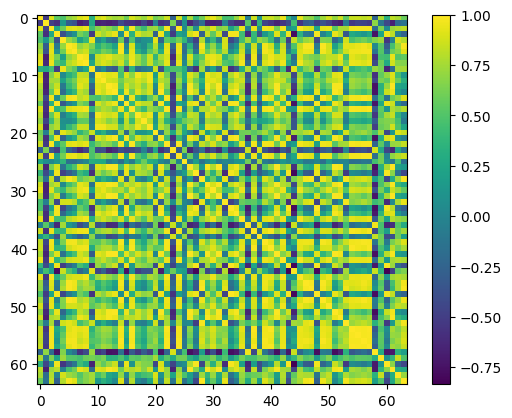

In [94]:
corr_matrix = np.corrcoef(normalized_representation[:64])
plt.imshow(corr_matrix, interpolation='nearest')
plt.colorbar()

In [95]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

cosine_similarity(representation[0], representation[64])

-0.03701705

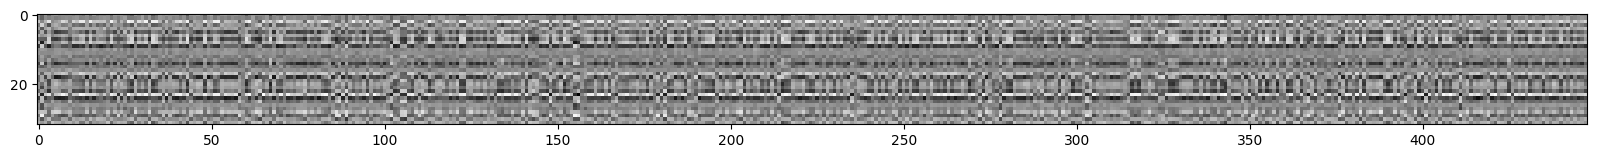

In [96]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.imshow(representation.T, cmap='gray', interpolation='nearest')


In [108]:
c = dataset_eval.data_csv['CMG'].to_numpy()

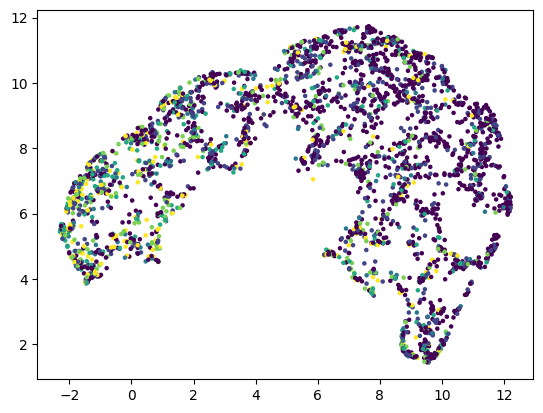

In [116]:
from matplotlib import pyplot as plt
from umap import UMAP

reducer = UMAP(n_components=2, n_neighbors=15, min_dist=0.05)
embedding = reducer.fit_transform(representation)

plt.scatter(embedding[:,0], embedding[:,1], c=label,s=5)

In [110]:
c

array([678., 660.,   0., ...,   0., 904., 486.])

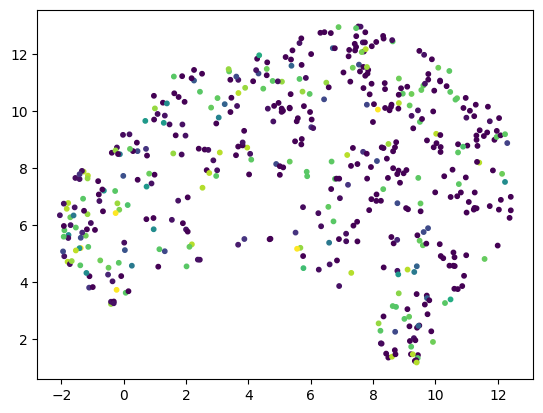

In [115]:
plt.scatter(embedding[:500,0], embedding[:500,1], c=c[:500],s=10)